In [36]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from model import LSTM_CRF_Model 
from torch.optim import Adam

from utils.plotting import *

# EDA

In [37]:
data = pd.read_csv("data/gpt_dataset.csv", sep=' ', header=None, names=['word', 'tag'])
data.head(5)

,word,tag
0,Everest,B-MOUNTAIN
1,is,O
2,the,O
3,highest,O
4,MOUNTAIN,O


In [38]:
# adding sentence indexing
current_sentence = 0
sentence_idx = []
data = data.dropna().reset_index(drop=True)
for word in data["word"]:
    sentence_idx.append(current_sentence)
    if word == '.':  
        current_sentence += 1

data['sentence_index'] = sentence_idx
grouped = data.groupby('sentence_index')
sentences = [s for s in grouped.apply(lambda x: [(w, t) for w,t in zip(x['word'].values.tolist(), x['tag'].values.tolist())])]
data["sentence_index"] = sentence_idx
data.head(12)

C:\Users\Admin\AppData\Local\Temp\ipykernel_26268\2726885576.py:12: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,word,tag,sentence_index
0,Everest,B-MOUNTAIN,0
1,is,O,0
2,the,O,0
3,highest,O,0
4,MOUNTAIN,O,0
5,in,O,0
6,the,O,0
7,world,O,0
8,.,O,0
9,K2,B-MOUNTAIN,1


In [39]:
grouped = data.groupby('sentence_index')
sentences = [s for s in grouped.apply(lambda x: [(w, t) for w,t in zip(x['word'].values.tolist(), x['tag'].values.tolist())])]
sentence_lengths = grouped.size()
sentence_length_data = pd.DataFrame({'sentence_index': sentence_lengths.index, 'length': sentence_lengths.values})
plot_hist(data=sentence_length_data, bins=7, xlabel='Sentence length', ylabel='Frequency', title='Number of words in each sentence')

C:\Users\Admin\AppData\Local\Temp\ipykernel_26268\1975025532.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



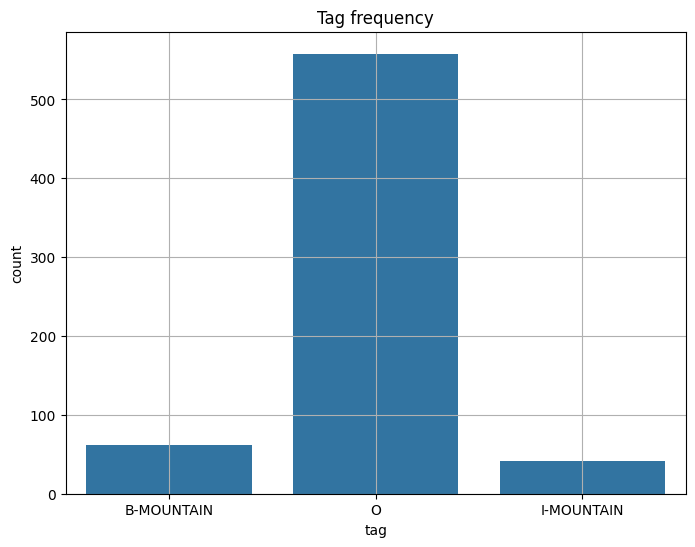

In [40]:
plt.figure(figsize=(8, 6))
sns.countplot(x='tag', data=data)
plt.title("Tag frequency")
plt.xlabel("tag")
plt.ylabel("count")
plt.grid()
%matplotlib inline
plt.show()

# Preprocessing

In [41]:
tags = list(set(data["tag"].values))
words = ["<PAD>", "<UNK>"] + list(set(data["word"].values))

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [42]:
numerical_sentences = []
numerical_tags = []

for sentence in sentences:
    _words, _tags = zip(*sentence)  # Separate words and tags
    numerical_sentences.append([word2idx.get(word, word2idx["<UNK>"]) for word in _words])
    numerical_tags.append([tag2idx[tag] for tag in _tags])

In [43]:
class NERDataset(Dataset):
    def __init__(self, sentences, tags, padding=True, pad_idx=None):
        self.sentences = sentences
        self.tags = tags
        self.padding = padding
        self.max_len = max(len(sentence) for sentence in sentences)
        print(f'{self.max_len = }')
        self.pad_idx = pad_idx
        
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        if (self.padding):
            sentence = self.sentences[idx]
            tag = self.tags[idx]    
            padded_sentence = sentence + [self.pad_idx] * (self.max_len - len(sentence))
            padded_tag = tag + [tag2idx["O"]] * (self.max_len - len(tag)) 
            return torch.tensor(padded_sentence), torch.tensor(padded_tag)

        return torch.tensor(self.sentences[idx]), torch.tensor(self.tags[idx])

dataset = NERDataset(numerical_sentences, numerical_tags, pad_idx=0)

self.max_len = 17


# Training

In [44]:
vocab_size = len(word2idx)
output_dim = len(tag2idx)
pad_idx = word2idx["<PAD>"]

model = LSTM_CRF_Model(vocab_size, embedding_dim=100, hidden_dim=128, output_dim=output_dim, pad_idx=pad_idx)
optimizer = Adam(model.parameters(), lr=1e-3)

In [45]:
batch_size = 8
epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

accuracy_stat = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for sentences, tags in train_loader:
        sentences = sentences.to(device) 
        tags = tags.to(device)
        optimizer.zero_grad()
        emissions = model(sentences, lengths=torch.tensor([len(s) for s in sentences]).to(device))
        loss = model.forward_crf(sentences, lengths=torch.tensor([len(s) for s in sentences]).to(device), tags=tags)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        predicted = model.forward_crf(sentences, lengths=torch.tensor([len(s) for s in sentences]).to(device))
        padded_predicted = [sublist + [0] * (tags.shape[1] - len(sublist)) for sublist in predicted]
        padded_predicted = torch.tensor(padded_predicted)
        tags_flat = tags.view(-1).to(device) 
        predicted = padded_predicted.view(-1).to(device) 
        mask = (tags_flat != 0) 
        predicted = predicted[mask]
        tags_flat = tags_flat[mask]

        correct += (predicted == tags_flat).sum().item()
        total += tags_flat.size(0) 

    accuracy_stat.append(correct / total * 100)
    print(f"Epoch {epoch + 1}/{epochs}, Accuracy: {correct / total * 100:.2f}%")


Epoch 1/25, Accuracy: 48.56%
Epoch 2/25, Accuracy: 55.10%
Epoch 3/25, Accuracy: 55.10%
Epoch 4/25, Accuracy: 55.50%
Epoch 5/25, Accuracy: 55.80%
Epoch 6/25, Accuracy: 57.09%
Epoch 7/25, Accuracy: 57.58%
Epoch 8/25, Accuracy: 58.47%
Epoch 9/25, Accuracy: 58.77%
Epoch 10/25, Accuracy: 59.07%
Epoch 11/25, Accuracy: 58.87%
Epoch 12/25, Accuracy: 58.97%
Epoch 13/25, Accuracy: 59.17%
Epoch 14/25, Accuracy: 59.17%
Epoch 15/25, Accuracy: 59.17%
Epoch 16/25, Accuracy: 59.27%
Epoch 17/25, Accuracy: 59.37%
Epoch 18/25, Accuracy: 59.27%
Epoch 19/25, Accuracy: 59.37%
Epoch 20/25, Accuracy: 59.46%
Epoch 21/25, Accuracy: 59.46%
Epoch 22/25, Accuracy: 59.37%
Epoch 23/25, Accuracy: 59.46%
Epoch 24/25, Accuracy: 59.46%
Epoch 25/25, Accuracy: 59.46%


c:\Users\Admin\quantum\ner\utils\plotting.py:46: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



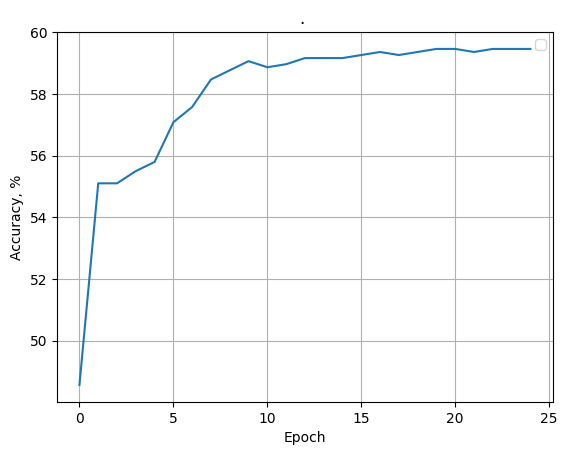

In [46]:
plt.plot(np.arange(len(accuracy_stat)), accuracy_stat)
plot_setup(xlabel='Epoch', ylabel='Accuracy, %')

In [47]:
torch.save(model, 'rnn_model.pth')